In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utilities as u

from keras.models import load_model
from pathlib import Path

# Surpress warnings related to NaNs
from warnings import filterwarnings

# Turn off Tensorflow Logs and other tensorflow options
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
filterwarnings('ignore')

2024-04-10 12:53:32.188547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-10 12:53:32.188581: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jannik/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Model directory / Network architecture
model_dir1 = "SuperResolution"
model_dir2 = "Surrogate"

# Additional run info
var = "Hs"
upfactor = 16
grid_in = (10, 10)
grid_out = (grid_in[0]*upfactor, grid_in[1]*upfactor)

# Test data serials
sample_start = 8761
sample_end = 17496
serial = np.arange(sample_start, sample_end+1, 1)

dim = 1

# Create output directory if needed
path_depth = Path("Data/DepthDependency")
path_depth.mkdir(parents=True, exist_ok=True)

# Save the figure?
save = True

In [3]:
fmodel1 = Path("Models") / model_dir1 / f"Model_Inp_{var}.hdf5"
fmodel2 = Path("Models") / model_dir2 / f"Model_Inp_{var}.hdf5"

model1 = load_model(fmodel1)
model2 = load_model(fmodel2)

# Load normalization constants for surrogate model
X_max, X_min = np.load("Data/Xmax_Xmin_2018_spectrum.npy")
bat_max, bat_min = np.load("Data/bat_max_bat_min_2018_spectrum.npy")

# Prepare file locations for reference and input data
fname_HR = f'Data/HR/{var}/BaskCoast_{var.upper()}_{{}}.npy'
fname_LR = f'Data/LR/{var}/BaskCoast_{var.upper()}_{{}}.npy'
fname_spec = 'Data/Spectrum/BaskCoast_{}.npy'
fname_bat = 'Data/Bathymetry/bat.npy'

# Output paths for computed arrays
path_dir = Path("Data/WholeTimeSeries")
path_dir.mkdir(parents=True, exist_ok=True)

fpath1 = (f"Var_{var}_{model_dir1}.npy")
fpath2 = (f"Var_{var}_{model_dir2}.npy")

path_arr1 = path_dir / fpath1
path_arr2 = path_dir / fpath2

2024-04-10 12:54:16.502309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-10 12:54:16.502791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-10 12:54:16.502930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-04-10 12:54:16.503052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-04-10 12:54:16.503169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

# Compute binned bathymetry and bin positions

In [4]:
nbins = 20

bathy = np.load("Data/Bathymetry/bat.npy").flatten()
bathy[bathy == 0] = np.nan

# Get edges of the bins
bat_range = (-5, np.nanmax(bathy))
bat_bins, edges = np.histogram(bathy, bins=nbins, range=bat_range)

# Calculate the mid-positions, by convolving over consecutive elements
mid_pos = np.convolve(edges, [0.5, 0.5], "valid")

# Load or compute super-resolution predictions

In [5]:
if path_arr1.exists():
    data = np.load(path_arr1)
    pred, hr, lr = data[0], data[1], data[2]
else:
    lr, hr = u.load_data((fname_HR, fname_LR), serial, var)
   
    lr = np.nan_to_num(lr)
    hr = np.nan_to_num(hr).flatten()
    pred = model1.predict(lr).flatten()
        
    lr = lr.repeat(upfactor, axis=1).repeat(upfactor, axis=2).flatten()

    data = np.row_stack((pred, hr, lr))

    np.save(path_arr1, data)

# Compute mean absolute differences in each bin for super-resolution and LR

In [6]:
fpath = path_depth / "SuperResolutionModel.npy"
fpath_lr = path_depth / "LowResolution.npy"

if fpath.exists() and fpath_lr.exists():
    mean_diff = np.load(fpath)
    mean_diff_lr = np.load(fpath_lr)
else:
    # Compute absolute differences and reshape
    diff = np.abs(pred - hr).reshape((-1, 160*160))
    del pred
    diff_lr = np.abs(hr - lr).reshape((-1, 160*160))
    del lr

    # Set zeroes to nan, otherwise empty land part is counted mean
    diff[diff == 0] = np.nan
    diff_lr[diff_lr == 0] = np.nan

    # Loop through bins and get median / mean differences
    mean_diff = np.empty(nbins)
    mean_diff_lr = np.empty(nbins)

    # Compute mean differences for each bin
    for i in range(nbins):
        condition = (edges[i] < bathy) & (bathy < edges[i+1])
        mean_diff[i] = np.nanmean(diff[:, condition])
        mean_diff_lr[i] = np.nanmean(diff_lr[:, condition])

    np.save(fpath, mean_diff)
    np.save(fpath_lr, mean_diff_lr)

# Load and compute surrogate model predictions

In [7]:
if path_arr2.exists():
    data = np.load(path_arr2)
    pred, hr = data[0], data[1]
else:
    nfreq, ntheta = 32, 24
    
    # Load training data and shift directional data if needed
    X, hr = u.load_data((fname_HR, fname_spec), serial, var, convert=False,
                         grid=(nfreq, ntheta), grid_out=grid_out)

    # Load bathymetry and tile to right length
    bat = np.load(fname_bat).reshape((1, *grid_out, dim))
    bat = np.tile(bat, (len(serial), 1, 1, 1))

    # Load normalization data
    X_max, X_min = np.load("Data/Xmax_Xmin_2018_spectrum.npy")
    bat_max, bat_min = np.load("Data/bat_max_bat_min_2018_spectrum.npy")
    
    # Normalize data
    X = (X - X_min) / (X_max - X_min)
    bat = (bat - bat_min) / (bat_max - bat_min)
    
    pred = model2.predict([X, bat]).flatten()
    hr = np.nan_to_num(hr).flatten()
    
    np.save(path_arr2, np.vstack([pred, hr]))


In [8]:
fpath_sur = path_depth / "SurrogateModel.npy"

if fpath_sur.exists():
    mean_sur = np.load(fpath_sur)
else:
    # Compute absolute differences
    diff = np.abs(pred - hr).reshape((-1, grid_out[0]*grid_out[1]))
    del pred

    diff[diff == 0] = np.nan

    # Compute mean differences for each bin
    mean_sur = np.empty(nbins)

    for i in range(nbins):
        condition = (edges[i] < bathy) & (bathy < edges[i+1])
        mean_sur[i] = np.nanmean(diff[:, condition])

    np.save(fpath_sur, mean_sur)

# Bin high-resolution data

In [9]:
fpath_hr = path_depth / "HighResolutionBinning.npy"

if fpath_hr.exists():
    mean_hr, min_hr, max_hr = np.load(fpath_hr)
else:
    # Loop through bins and get median / mean differences
    mean_hr = np.empty(nbins)
    min_hr = np.empty(nbins)
    max_hr = np.empty(nbins)

    hr = hr.reshape((-1, 160*160))

    for i in range(nbins):
        condition = (edges[i] < bathy) & (bathy < edges[i+1])
        mean_hr[i] = np.nanmean(hr[:, condition])
        min_hr[i] = np.nanmin(hr[:, condition])
        max_hr[i] = np.nanmax(hr[:, condition])

    del hr

    np.save(fpath_hr, np.vstack([mean_hr, min_hr, max_hr]))

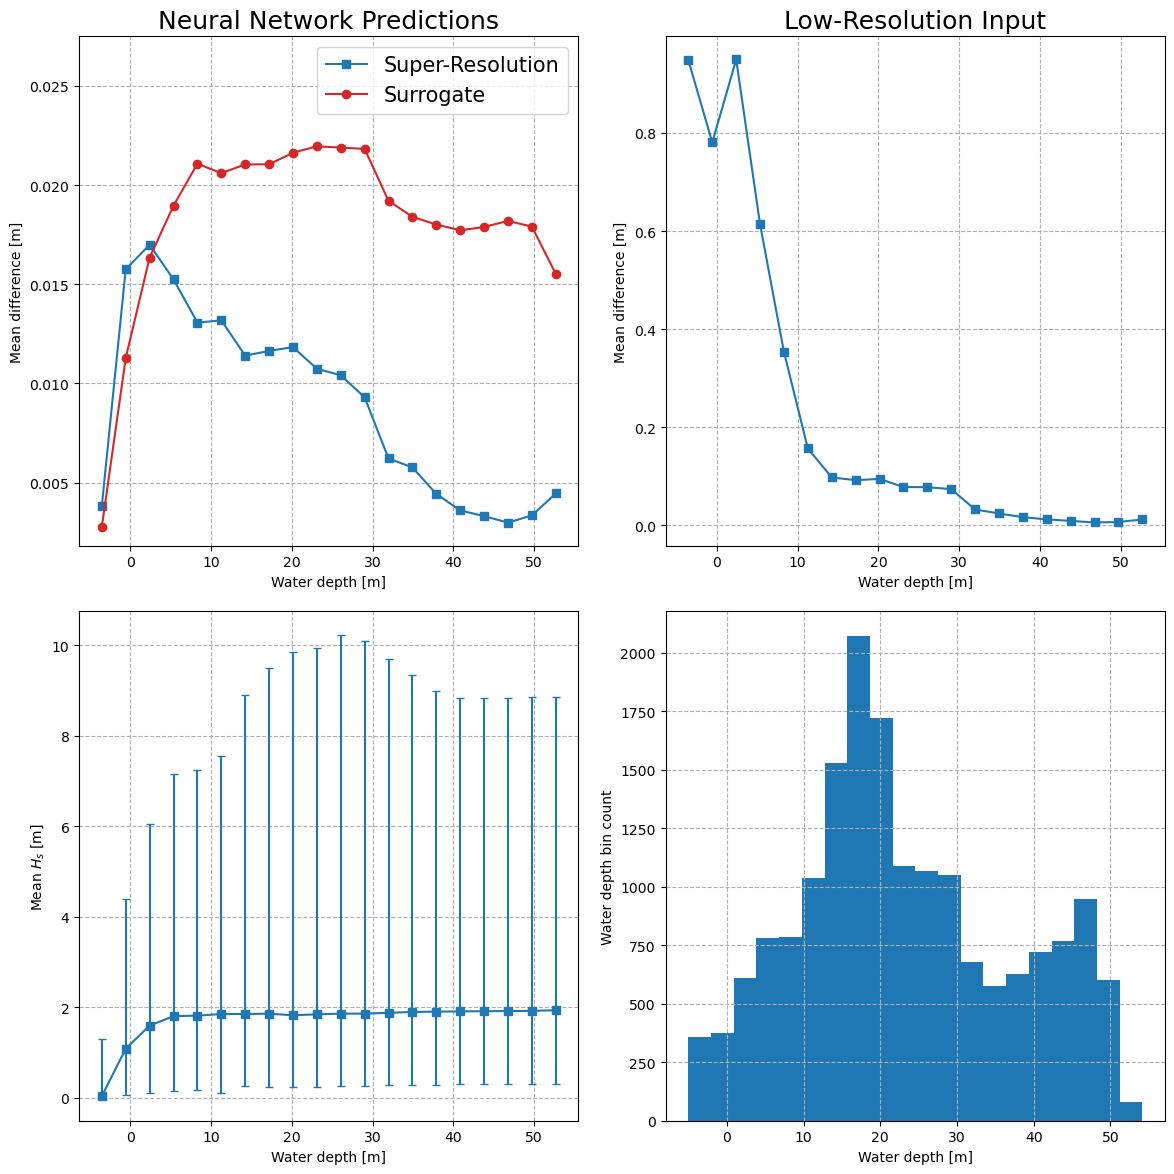

In [10]:
LABELSIZE = 15
TICKLABELSIZE = 13
LEGENDFONTSIZE = 12

errorbars = np.vstack([mean_hr-min_hr, max_hr-mean_hr])

fig, axs = plt.subplot_mosaic([["bat", "bat_lr"],
                               ["bat_hr", "nbat"]], figsize=(12, 12))

plot_dict = {
    'font.size': LABELSIZE,
    'xtick.labelsize': TICKLABELSIZE,
    'ytick.labelsize': TICKLABELSIZE
}


plt.rcParams.update(plot_dict)

axs["bat"].plot(mid_pos, mean_diff, "-s", label="Super-Resolution",
                color="tab:blue")
axs["bat"].plot(mid_pos, mean_sur, "-o", label="Surrogate",
                color="tab:red")

axs["bat"].set_xlabel("Water depth [m]")
axs["bat"].set_ylabel("Mean difference [m]")
axs["bat"].set_ylim(top=0.0275)
axs["bat"].grid(True, axis="both", ls="--")
axs["bat"].set_title("Neural Network Predictions")
axs["bat"].legend()

axs["bat_lr"].plot(mid_pos, mean_diff_lr, "-s")

axs["bat_lr"].set_xlabel("Water depth [m]")
axs["bat_lr"].set_ylabel("Mean difference [m]")

axs["bat_lr"].grid(True, axis="both", ls="--")
axs["bat_lr"].set_title("Low-Resolution Input")

axs["nbat"].hist(bathy, bins=nbins, range=bat_range)

axs["nbat"].set_xlabel("Water depth [m]")
axs["nbat"].set_ylabel("Water depth bin count")

axs["nbat"].grid(True, axis="both", ls="--")

axs["bat_hr"].errorbar(mid_pos, mean_hr, errorbars, fmt="-s", capsize=3)

axs["bat_hr"].set_xlabel("Water depth [m]")
axs["bat_hr"].set_ylabel(r"Mean $H_s$ [m]")
axs["bat_hr"].grid(True, axis="both", ls="--")


plt.tight_layout()

plt.savefig("Plots/ErrorWithBathymetry.png")
plt.show()